In [1]:
import sys 
import os.path

import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
mnist = fetch_mldata('MNIST original', data_home='mnist')
mnist.DESCR

'mldata.org dataset: mnist-original'

In [3]:
lb = LabelBinarizer()
lb.fit(mnist.target)
# encode target labels as zero-mean one hot encoded vector 
# with negative class = -0.1 and positive class as 0.9
encode = lambda y: lb.transform(y) - .1

In [4]:
image_train, image_test, label_train, label_test = train_test_split(
    mnist.data, mnist.target, stratify = mnist.target, random_state = 444, test_size=.15)

X_test = image_test
y_test = encode(label_test)

X_train = image_train
y_train = encode(label_train)

In [5]:
def get_train_subset(n):
    x, _, y, _ = train_test_split(image_train, label_train, stratify = label_train, random_state=333, train_size = n)
    return x, encode(y)

def accuracy(y, y_hat):
    return np.mean(np.argmax(y, axis = 1) == np.argmax(y_hat, axis = 1))

In [6]:
def train_or_load_model(nn_width, sample_size):
    model_path = 'models/mnist_w%d_s%d' % (nn_width, sample_size)
    if(os.path.isfile(model_path)):
        model = load_model(model_path)
    else:
        model = Sequential()
        model.add(Dense(nn_width, input_dim=784, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(10, kernel_initializer='normal'))
        model.compile(loss='mean_squared_error', optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))
        X_train, y_train = get_train_subset(sample_size)
        model.fit(X_train, y_train, epochs = 100, batch_size = 256, verbose = 0)
        model.save(model_path)
    return model

In [7]:
sample_sizes = np.array([1000, 5000, 10000, 25000, 50000])
nn_widths = np.array([5, 10, 50, 100, 500, 1000])

nn_results = np.empty((sample_sizes.shape[0], nn_widths.shape[0], 2))

for i, sample_size in enumerate(sample_sizes):
    for j, nn_width in enumerate(nn_widths):
        m = train_or_load_model(nn_width = nn_width, sample_size = sample_size)
        y_hat = m.predict(X_test)
        nn_results[i, j, 0] = accuracy(y_test, y_hat)  
        nn_results[i, j, 1] = mean_squared_error(y_test, y_hat)
    print('done sample size %d' % sample_size)

done sample size 1000
done sample size 5000
done sample size 10000
done sample size 25000
done sample size 50000


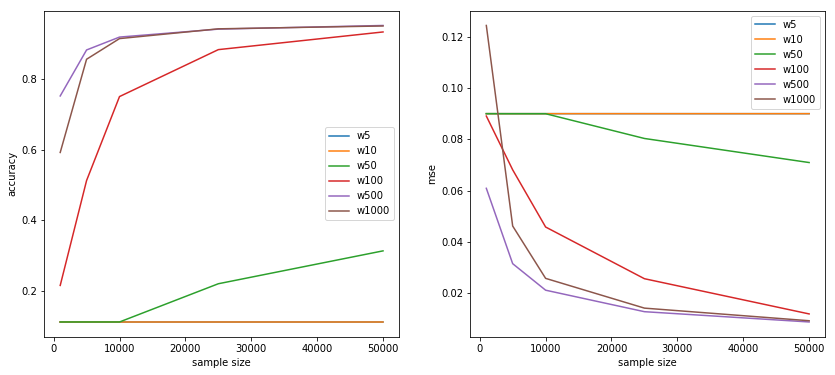

In [9]:
plt.figure(figsize = (15, 6))

plt.subplot(121)

for j, nn_width in enumerate(nn_widths):
    plt.plot(sample_sizes, nn_results[:, j, 0], label='w%d' % nn_width)
plt.xlabel('sample size')
plt.legend()
_ = plt.ylabel('accuracy')

plt.subplot(122)

for j, nn_width in enumerate(nn_widths):
    plt.plot(sample_sizes, nn_results[:, j, 1], label='w%d' % nn_width)
plt.xlabel('sample size')
plt.legend()
_ = plt.ylabel('mse')